# **TASK 5 : Attention-based NMT**

This tasks aims to give you a better practical understanding of Attention mechanisms as they fell short in the Assignments.
In this task, you will implement a simple NMT with attention for a language pair of your choice.
We will follow the corresponding TF Tutorial on NMT.

Please do not use the exemplary English-Spanish example to reduce temptation of simply copying the tutorial.
You can find data sets here. I recommend to pick a language pair where you understand both languages.
This makes it easier (and more fun) for you to evaluate the results.

Recommendation: Start with a small number of training examples. Use one of the training examples to evaluate whether training worked properly.
Only switch to the complete data set if you’re sure that your code works, because training is quite slow.
Note that many words are out-of-vocabulary (OOV) when using few examples.

Tasks:

Follow the tutorial and train the model on your chosen language pair (using Bahdanau attention).
You might need to adapt the preprocessing depending on the language.
Implement other attention mechanisms and train models with them
dot product attention 
Luong’s multiplicative attention 
Hint: Storing the models is important, so you don’t need to retrain them all the time.
Also take care to not overwrite model checkpoints when switching from additive to multiplicative attention.

Compare the attention weight plots for some examples between the attention mechanisms.
I recommend to add ,clim=[0,1] when creating the plot in ax.matshow(attention, cmap='viridis') so the colors correspond to the same attention values in different plots.
Note that the tutorial crops off the padding in the attention plot although the decoder can attend to those too.
Do you see qualitative differences in the attention weights between different attention mechanisms?
Do you think that the model attends to the correct tokens in the input language? (if you understand both languages)

Here are a few questions for you to check how well you understood the tutorial.
Please answer them (briefly) in your solution!

Which parts of the sentence are used as a token? Each character, each word, or are some words split up?
Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?
What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?
(for the architecture used in the tutorial)
Is the decoder attending to all previous positions, including the previous decoder predictions?
Does the Encoder output change in different decoding steps?
Does the context vector change in different decoding steps?
The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?
Why is a mask applied to the loss function?
Bonus1: Can you prevent the attention mechanism from attending to padded positions in the sequence?

Bonus2: The tutorial suggests to restore checkpoints for loading a model.
This is inconvenient, because you first need to process the data, build the whole architecture and then initialize it from the checkpoint.
It would be much nicer to simply load a model and run translations with it. Can you find a way to achieve this?

In [5]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [6]:
from google.colab import drive
drive.mount('/content/drive')
path_to_zip = '/content/drive/My Drive/Colab Notebooks/IDL_FinalSubmission/'
path_to_file = os.path.dirname(path_to_zip)+"/deu.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print(path_to_file)

/content/drive/My Drive/Colab Notebooks/IDL_FinalSubmission/deu.txt


In [8]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [9]:
en_sentence = u"May I borrow this book?"
de_sentence = u"Darf ich dieses Buch ausleihen?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(de_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> darf ich dieses buch ausleihen ? <end>'


In [10]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [11]:
en, de = create_dataset(path_to_file, None)
print(en[-1])
print(de[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , dass seit erschaffung ebenderselben wohl noch 

In [13]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [14]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
# Try experimenting with the size of that dataset
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [16]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

120000 120000 30000 30000


In [17]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[2460])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[2460])

Input Language; index to word mapping
1 ----> <start>
20 ----> wir
37 ----> haben
753 ----> thomas
9 ----> nicht
1167 ----> getotet
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
21 ----> we
58 ----> didn
11 ----> t
530 ----> kill
5 ----> tom
3 ----> .
2 ----> <end>


In [19]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 24]), TensorShape([64, 14]))

In [21]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 24, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## Bahdanau Attention

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    print(attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

(64, 24, 1)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 24, 1)
Decoder output shape: (batch_size, vocab size) (64, 11205)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = './training_checkpoints_Bahdanau'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1)
Epoch 1 Batch 0 Loss 4.9845
Epoch 1 Batch 100 Loss 2.4267
Epoch 1 Batch 200 Loss 2.3312
Epoch 1 Batch 300 Loss 2.0875
Epoch 1 Batch 400 Loss 1.9651
Epoch 1 Batch 500 Loss 1.9477
Epoch 1 Batch 600 Loss 1.8869
Epoch 1 Batch 700 Loss 1.7315
Epoch 1 Batch 800 Loss 1.7050
Epoch 1 Batch 900 Loss 1.6099
Epoch 1 Batch 1000 Loss 1.5492
Epoch 1 Batch 1100 Loss 1.5104
Epoch 1 Batch 1200 Loss 1.4790
Epoch 1 Batch 1300 Loss 1.5133
Epoch 1 Batch 1400 Loss 1.3258
Epoch 1 Batch 1500 Loss 1.2591
Epoch 1 Batch 1600 Loss 1.4278
Epoch 1 Batch 1700 Loss 1.3065
Epoch 1 Batch 1800 Loss 1.1346
Epoch 1 Loss 1.6845
Time taken for 1 epoch 254.39041805267334 sec

Epoch 2 Batch 0 Loss 1.1075
Epoch 2 Batch 10

In [26]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [28]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(1, 24, 1)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1)
Input: <start> apfel ist rot . <end>
Predicted translation: apples is red . <end> 


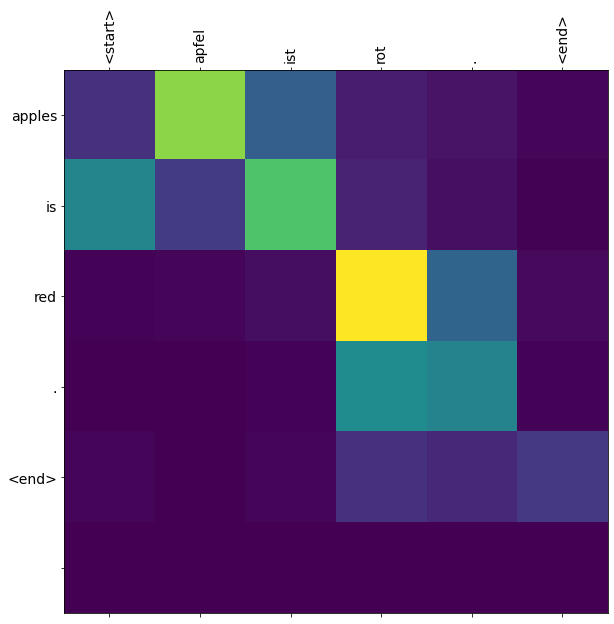

In [30]:
translate(u'Apfel ist rot.')

## Luongs Multiplicative Attention

In [30]:
class LuongsMultiplicativeAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongsMultiplicativeAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    
    #query_with_time_axis = tf.expand_dims(query, 1)
    #temp = tf.matmul(query_with_time_axis, self.W, transpose_a=True)  # (..., seq_len_q, seq_len_k)
    temp = self.W(values)
    #temp = tf.matmul(tf.transpose(query_with_time_axis),self.W)
    query_with_time_axis = tf.expand_dims(query, 1)
    score =  tf.matmul(temp, query_with_time_axis, transpose_b=True)
    #score = query_with_time_axis * temp
    print(temp.shape)
    print(query_with_time_axis.shape)
    print(score.shape)
    #query_with_time_axis(T) * self.W1 * values
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    #score = self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
   
    attention_weights = tf.nn.softmax(score, axis=1)
    print(attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [31]:
attention_layer = LuongsMultiplicativeAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [32]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongsMultiplicativeAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [33]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
Decoder output shape: (batch_size, vocab size) (64, 11205)


In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [35]:
checkpoint_dir = './training_checkpoints_Luongs'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [36]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 24, 1)
(64, 24, 1024)
(64, 1, 1024)
(64, 24, 1)
(64, 

In [37]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [38]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [39]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
(1, 24, 1024)
(1, 1, 1024)
(1, 24, 1)
(1, 24, 1)
Input: <start> apfel ist rot . <end>
Predicted translation: verdict quickest petition gauge zookeeper dissatisfaction haven magda governed shouts believes passed zookeeper dissatisfaction 


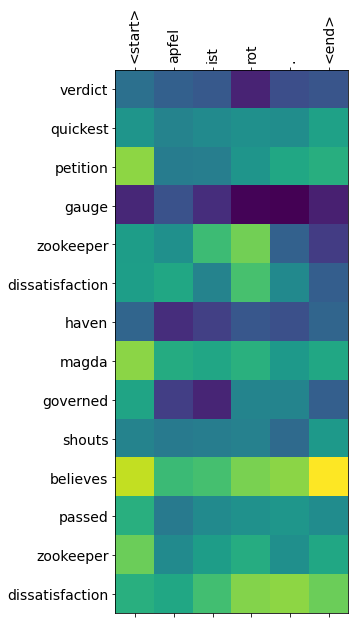

In [41]:
translate(u'Apfel ist rot.')

## Dot Product Attention

In [42]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(DotProductAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score =  tf.matmul(values,query_with_time_axis, transpose_b=True)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [43]:
attention_layer = DotProductAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [44]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotProductAttention(self.dec_units)


  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [45]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11205)


In [47]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [48]:
checkpoint_dir = './training_checkpoints_Luongs'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [49]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [50]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9635
Epoch 1 Batch 100 Loss 2.5449
Epoch 1 Batch 200 Loss 2.1980
Epoch 1 Batch 300 Loss 2.1924
Epoch 1 Batch 400 Loss 1.9817
Epoch 1 Batch 500 Loss 1.7522
Epoch 1 Batch 600 Loss 1.6632
Epoch 1 Batch 700 Loss 1.5089
Epoch 1 Batch 800 Loss 1.6933
Epoch 1 Batch 900 Loss 1.5791
Epoch 1 Batch 1000 Loss 1.4389
Epoch 1 Batch 1100 Loss 1.5292
Epoch 1 Batch 1200 Loss 1.5129
Epoch 1 Batch 1300 Loss 1.3115
Epoch 1 Batch 1400 Loss 1.3613
Epoch 1 Batch 1500 Loss 1.3547
Epoch 1 Batch 1600 Loss 1.2338
Epoch 1 Batch 1700 Loss 1.2335
Epoch 1 Batch 1800 Loss 1.1881
Epoch 1 Loss 1.6372
Time taken for 1 epoch 284.8163137435913 sec

Epoch 2 Batch 0 Loss 1.1936
Epoch 2 Batch 100 Loss 1.0333
Epoch 2 Batch 200 Loss 0.9958
Epoch 2 Batch 300 Loss 0.8707
Epoch 2 Batch 400 Loss 1.0018
Epoch 2 Batch 500 Loss 0.9451
Epoch 2 Batch 600 Loss 0.9598
Epoch 2 Batch 700 Loss 0.9520
Epoch 2 Batch 800 Loss 0.8908
Epoch 2 Batch 900 Loss 0.9786
Epoch 2 Batch 1000 Loss 0.9139
Epoch 2 Batch 1100 Loss 0.78

In [51]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [52]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [53]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [54]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> apfel ist rot . <end>
Predicted translation: red is red . <end> 


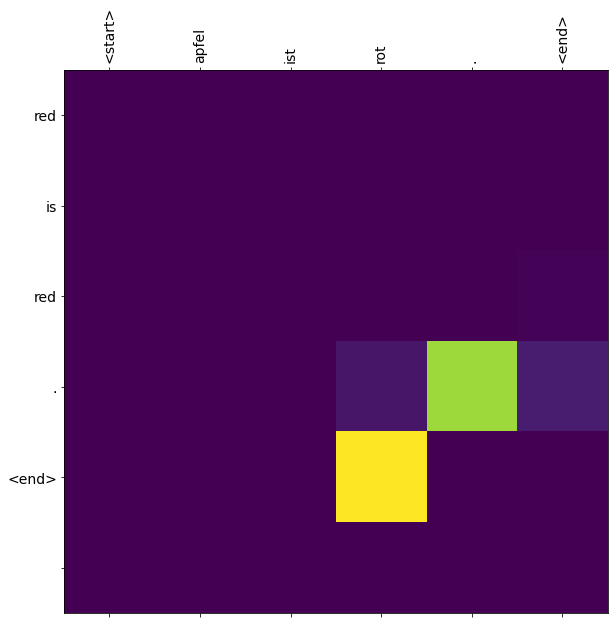

In [56]:
translate(u'Apfel ist rot.')

# Assignment questions -


- Which parts of the sentence are used as a token? Each character, each word, or are some words split up?  
Answer: Each word is used as a token. No words are split up during the formation of tokens. During pre-processing, all special characters except ".", "?", "!", "," are removed. All alphabets are retained. The pre-processing also takes into consideration the extra german alphabets.
<br>
<br>
- Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?  
Answer: The tokens that are same in both the languages, do not have the same ID. As per the example given below, the token "die" has different IDs.<br>
<pre>
Input Language; index to word mapping
1 ----> <start>
12 ----> du
44 ----> hast
33 ----> eine
3791 ----> alternative
3 ----> .
2 ----> <end>
</pre>
<pre>
Target Language; index to word mapping
1 ----> <start>
6 ----> you
20 ----> have
82 ----> an
3392 ----> alternative
3 ----> .
2 ----> <end>
</pre>
<br>
<br>
- What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?
(for the architecture used in the tutorial)  
Answer:  The model reads the input sequence one at a time, and builds the hidden state for each input. However, the output of this model is only generated when the input sequence is completely processed, thus making the model asynchronous. This output is generated by applying a transformation on the last hidden state, which now contains all the information about the input sequence contents. The output will then be compared with the desired output y, in order to generate the loss value. The output is not a sequence anymore, but is a single value in vector format.
<br>
<br>
- Is the decoder attending to all previous positions, including the previous decoder predictions?  
Answer: The decoder has input from output of previous timestep, usually with output-to-hidden connections. The decoder takes into consideration the previous predictions, while computing for the current timestep.
<br>
<br>
- Does the Encoder output change in different decoding steps?  
Answer: During decoding process, if the output is not as expected, then by backpropagation, gradients can travel upto the encoder that contributed to the information that was used to make the prediction at that time. Thus the encoder output may change for different decoding steps.
<br>
<br>
- Does the context vector change in different decoding steps?  
Answer: Yes, the context vector is dynamic and changes for each decoding step. The context vector is the aggregated attention of the weighted sum of the encoder hidden states. During the decoding steps, it is possible to have updated attention weights, which in turn lead to an updated context vector.
<br>
<br>
- The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?  
Answer: In teacher forcing, the expected output is concatenated with the actual output, and passed to the next timestep. This still needs the sequential input from the previous timestep, and therefore the computation cannot be parallelized. RNNs can only be parallelized if all the connections are ground-truth to hidden connections.
<br>
<br>
- Why is a mask applied to the loss function?  
The samples provided as input are not of the same length. We pad the input before the training so as to make the input of a standard length. Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. 